In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.fftpack as fft
import seaborn as sns
# from mpl_toolkits import basemap
import geopandas
import cartopy
pd.options.display.max_columns = 999
pd.options.display.max_rows = 77

%matplotlib inline

In [2]:
def read_data(filename, usecols=[2, 5, 8, 19, 20], dtype={'Primary Type': str, 'Arrest': bool, 'Latitude' : float, 'Longitude' : float}, **kwargs):

    data = pd.read_csv(filename, usecols=usecols, dtype=dtype, quotechar='"', index_col='Date', **kwargs)
    data.index = pd.to_datetime(data.index, format='%m/%d/%Y %I:%M:%S %p')
    return data

In [3]:
def add_counts(crime_df, crime_type=None):
    """Add the counts by function of hour, day, month, and year
    
    If crime_type is None, then all crimes. Otherwise, for crime_type only"""
    
    crime_count_dict = {}
    
    if crime_type is not None and str.lower(crime_type) != 'all':
        crime_df = crime_df[crime_df['Primary Type'] == str.upper(crime_type)]
    
    if len(crime_df) == 0:
        raise KeyError('Invalid crime type')
    
    crime_count_dict['hour'] = crime_df.index.hour.value_counts().astype(float)
    crime_count_dict['weekday'] = crime_df.index.weekday.value_counts().astype(float)
    crime_count_dict['day'] = crime_df.index.day.value_counts().astype(float)
    crime_count_dict['month'] = crime_df.index.month.value_counts().astype(float)
    crime_count_dict['year'] = crime_df.index.year.value_counts().astype(float)
    
    return crime_count_dict

In [219]:
def plot_counts(counts, ax, weights=None, bar=True, do_err=False, **kwargs):
    """Provide bar position and heights for crime counts
    
    if weights is not None, weightsalize 
    If bar false, do a line plot
    """
    xs = counts.index
    vals = counts.values / counts.values.sum()
    
    if weights is not None:
        try:
            vals *= weights
        except TypeError:
            if weights.lower() == 'month':
                weights = 1. / np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) * 30. 
                #technically Feb is 28.25?
            elif weights.lower() == 'day':
                weights = np.ones(31)
                weights[30] = 12./7
                weights[29] = 12./11
                weights[28] = 12./11
            else:
                print(f'Unrecognized weights: {weights}')
                weights = np.ones(len(xs))
            assert len(weights) == len(xs)
            vals *= weights
    if bar:
        ax.bar(xs, vals, **kwargs)
    else:
        if do_err:
            ax.errorbar(np.sort(xs), vals[np.argsort(xs)], yerr=np.sqrt(counts.values)/counts.values.sum(), **kwargs)
        else:
            ax.plot(np.sort(xs), vals[np.argsort(xs)], **kwargs)

In [177]:
nrows = None
filename = '/home/elaad/Documents/Fun/DatAnalysis/datasets/Crimes_-_2001_to_present.csv'
crimedata = read_data(filename, nrows=nrows, usecols=None, dtype=None)
print(len(crimedata[crimedata.Longitude <= -90]))
crimedata = crimedata[crimedata.Longitude > -90] # getting rid of a few unexpected outliers beyond the city limits
crimedata.sort_index(inplace=True)

/home/elaad/miniconda3/envs/chicago/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


163


In [223]:
census_dat = pd.read_excel('/home/elaad/Documents/Fun/DatAnalysis/datasets/CCASF12010CMAP.xlsx',
                          index_col=1, header=1, skiprows=0)

# Overview

What are the most common crimes?

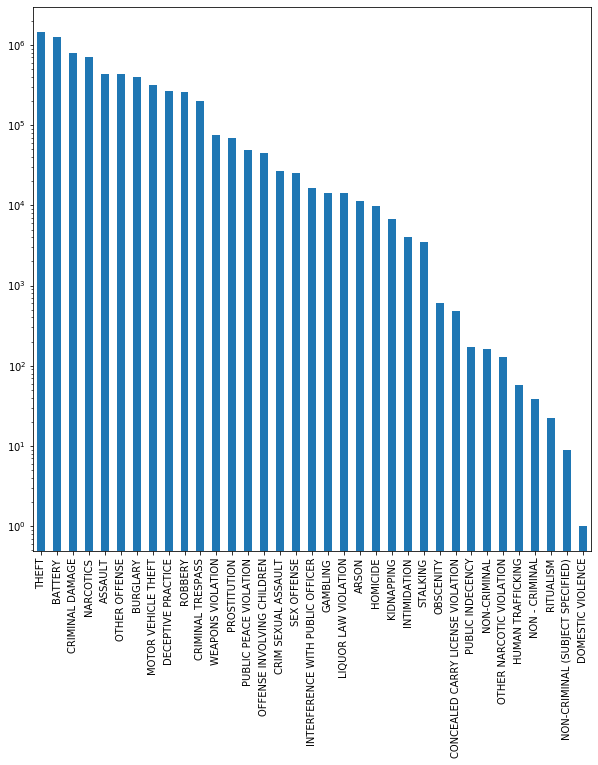

In [6]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
crimedata['Primary Type'].value_counts().plot(kind='bar', ax=ax)
ax.set_yscale('log')

So, thefts are the most common crime, followed by battery. This is not terribly surprising. Of, say, thefts, what are the most common descriptors?

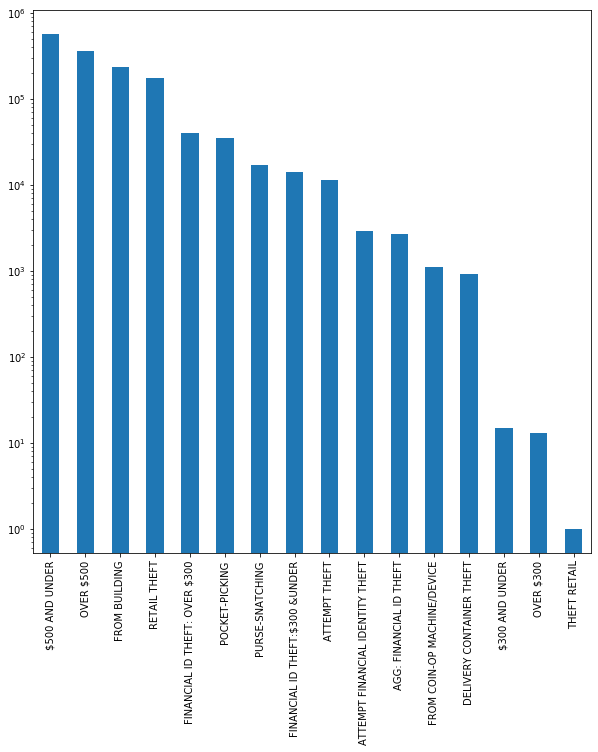

In [7]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
crimedata[crimedata['Primary Type'] == 'THEFT']['Description'].value_counts().plot(kind='bar', ax=ax)
ax.set_yscale('log')

The most common theft description is \\$500 and under, followed by over \\$500; small amounts are more common than large. For Financial ID Theft, however, it is the other way around, with higher amounts more common.

Retail theft has one reported incidence; I should look into this. Under-reporting, or inconsistent descriptor?

# Crimes as a function of time and date

Some assumptions certainly go into the believability of these plots.
For example:
* Listed information---particularly dates and times---are accurate (the overabundance of crimes on the first of the month casts doubt on this assumption)

In [209]:
crime_counts = {}
for crime_type in ['all', 'homicide', 'theft']:
    crime_counts[crime_type] = add_counts(crimedata, crime_type)

Unrecognized weights: hour
Unrecognized weights: hour
Unrecognized weights: hour
Unrecognized weights: weekday
Unrecognized weights: weekday
Unrecognized weights: weekday
Unrecognized weights: year
Unrecognized weights: year
Unrecognized weights: year


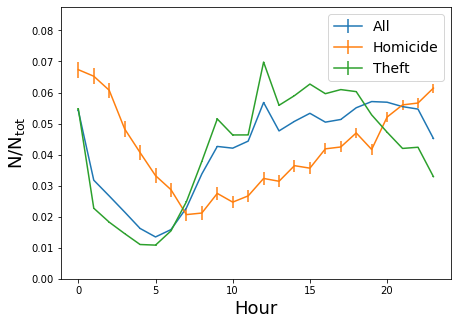

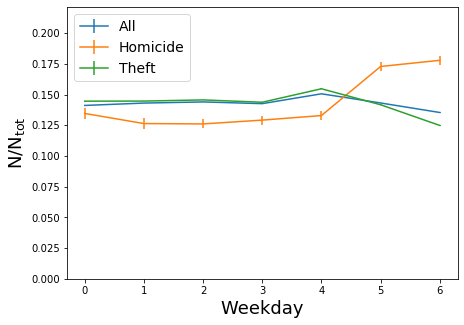

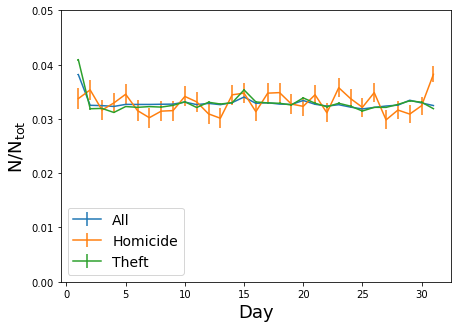

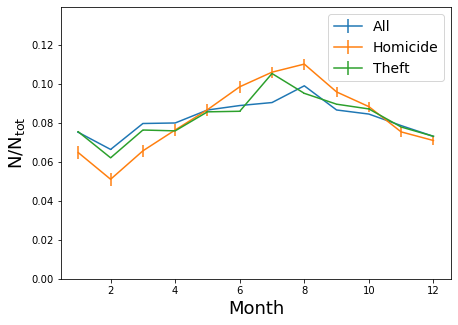

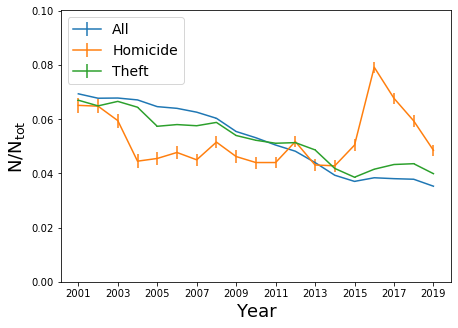

In [220]:
for time_interval in crime_counts['all']:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)
    for crime_type, color, hatch in zip(crime_counts, [f'C{i}' for i in range(len(crime_counts))],
                                ['//', '\\\\', '--']):
        plot_counts(crime_counts[crime_type][time_interval], ax, weights=time_interval, bar=False, do_err=True,
                    label=crime_type.capitalize(), color=color,)# alpha=1./len(crime_counts),)
#                     hatch=hatch)
    ax.legend(loc='best', fontsize=14)
    ax.set_xlabel(time_interval.capitalize(), fontsize=18)
    ax.set_ylabel('N/N$_\mathrm{tot}$', fontsize=18)
    ax.set_ylim([0, ax.set_ylim()[-1] * 1.2])
    if time_interval == 'year':
        ax.set_xticklabels([str(year) for year in np.arange(2001, 2021, 2)])
        ax.set_xticks(np.arange(2001, 2021, 2))

#     plot_counts(homicide_hourcounts, subplot=ax, label='Homicide', facecolor='none', edgecolor='orange')
# ax.set_xlabel('Hour of Day', fontsize=18)
# ax.set_ylabel('N$_\mathrm{crime}$/N$_\mathrm{tot}$', fontsize=18)
# plt.legend(loc='best')

# weekdays = ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su']
# fig, ax = plt.subplots(1, 1)
# plot_counts(allcrime_weekdaycounts, subplot=ax, label='All Crimes', facecolor='none', edgecolor='blue')
# plot_counts(homicide_weekdaycounts, subplot=ax, label='Homicide', facecolor='none', edgecolor='orange',
#     tick_label=weekdays)
# ax.set_xlabel('Day of Week', fontsize=18)
# ax.set_ylabel('Number of Crimes', fontsize=18)
# plt.legend(loc='best')

A few interesting things to note here. Crimes generally seem to be least frequent around 5 AM, while homicides bottom out around 7 AM. Homicides also seem to peak a bit later than most crimes. Thefts, on the other hand, peak in the afternoon (except for a single spike around noon, which I will assume for now comes from thefts around the lunch hour. To test this I should see which specific types of theft are contributing to the spike). All of these observations are consistent with a general idea that most crimes require people to be around, while homicides occure when people *aren't* around.

There aren't strong trends with day of the week, except for a weekday/weekend divide. Homicides are less common on weekdays and more common on weekends, while other crimes are generally more common during the week. Future work will require separating crimes geographically. How much of this trend comes from crimes being concentrated in business areas?

For day of the month, I have weighted the histograms so that long months have their extra days' counts proportionately increased. With the exception of the first and last day of the month, variations look like noise. I assume (for now) that the differences in the first/last days are reporting biases of some sort.

In [45]:
# fig, ax = plt.subplots(1, 1)
# ax.bar(allcrime_hourcounts.index, allcrime_hourcounts.values/allcrime_hourcounts.values.sum(), label='All Crimes', facecolor='none', edgecolor='blue')
# ax.bar(homicide_hourcounts.index, homicide_hourcounts.values/homicide_hourcounts.values.sum(), label='Homicide', facecolor='none', edgecolor='orange')
# ax.set_xlabel('Hour of Day', fontsize=18)
# ax.set_ylabel('Number of Crimes', fontsize=18)
# plt.legend(loc='best')

# weekdays = ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su']
# fig, ax = plt.subplots(1, 1)
# ax.bar(allcrime_weekdaycounts.index, allcrime_weekdaycounts.values/allcrime_weekdaycounts.values.sum(), label='All Crimes', facecolor='none', edgecolor='blue', tick_label=weekdays)
# ax.bar(homicide_weekdaycounts.index, homicide_weekdaycounts.values/homicide_weekdaycounts.values.sum(), label='Homicide', facecolor='none', edgecolor='orange', tick_label=weekdays)
# ax.set_xlabel('Day of Week', fontsize=18)
# ax.set_ylabel('Number of Crimes', fontsize=18)
# plt.legend(loc='best')

# fig, ax = plt.subplots(1, 1)
# ax.bar(allcrime_daycounts.index, allcrime_daycounts.values/allcrime_daycounts.values.sum(), label='All Crimes', facecolor='none', edgecolor='blue')
# ax.bar(homicide_daycounts.index, homicide_daycounts.values/homicide_daycounts.values.sum(), label='Homicide', facecolor='none', edgecolor='orange')
# ax.set_xlabel('Day of Month', fontsize=18)
# ax.set_ylabel('Number of Crimes', fontsize=18)
# plt.legend(loc='best')

# fig, ax = plt.subplots(1, 1)
# ax.bar(allcrime_monthcounts.index, allcrime_monthcounts.values/allcrime_monthcounts.values.sum(), label='All Crimes', facecolor='none', edgecolor='blue')
# ax.bar(homicide_monthcounts.index, homicide_monthcounts.values/homicide_monthcounts.values.sum(), label='Homicide', facecolor='none', edgecolor='orange')
# ax.set_xlabel('Month of Year', fontsize=18)
# ax.set_ylabel('Number of Crimes', fontsize=18)
# plt.legend(loc='best')

# fig, ax = plt.subplots(1, 1)
# ax.bar(allcrime_yearcounts.index, allcrime_yearcounts.values/allcrime_yearcounts.values.sum(), label='All Crimes', facecolor='none', edgecolor='blue')
# ax.bar(homicide_yearcounts.index, homicide_yearcounts.values/homicide_yearcounts.values.sum(), label='Homicide', facecolor='none', edgecolor='orange')
# ax.set_xlabel('Year', fontsize=18)
# ax.set_ylabel('Number of Crimes', fontsize=18)
# plt.legend(loc='best')

In [14]:
geodf = geopandas.read_file('../datasets/Boundaries_Community_Areas/')

In [289]:
subview = crimedata.loc[crimedata['Year'] == 2019]
neighborhood_counts = subview[subview['Primary Type'] == 'HOMICIDE']['Community Area'].value_counts(sort=False)
neighborhood_counts = neighborhood_counts.reindex(index=geodf['area_num_1'].astype(int), fill_value=0)
neighborhood_rates = 1e5 * neighborhood_counts / census_dat['Total Population'] / len(subview['Year'].value_counts())

In [304]:
cmap1 = plt.cm.ScalarMappable(cmap='Blues')
cmap1.set_clim(0, neighborhood_rates.max())

To do -- make a gif of this over time (murder rate per year...)

In [353]:
neighborhood_rates

1       9.092397
2       4.170026
3       0.000000
4       0.000000
5       3.138042
6       1.059681
7       4.679019
8       2.484966
9       8.938947
10      0.000000
11      0.000000
12      0.000000
13      0.000000
14      1.940165
15      4.678436
16      5.622294
17     14.308881
18      0.000000
19      5.079817
20      0.000000
21      5.093984
22      5.495185
23     47.937787
24      6.080062
25     50.754208
26    133.325926
27     77.794525
28     14.576994
29     66.830029
30     17.657149
31     13.978585
32      3.414951
33      4.675082
34     14.935404
35     16.449172
36     16.897601
37    139.082058
38     22.800857
39      5.605067
40     93.880686
41      0.000000
42     33.698399
43     38.454143
44     35.451850
45     29.455081
46     51.285339
47      0.000000
48      7.240081
49     62.753535
50     40.955631
51     13.237143
52     26.039406
53     20.235405
54     46.282012
55      0.000000
56      8.692377
57      0.000000
58      4.408394
59      6.4053

In [329]:
census_dat.loc[neighborhood_rates.sort_values(ascending=False).index]

,Geog,Total Population,"Not Hispanic or Latino, White alone","Not Hispanic or Latino, Black or African American alone","Not Hispanic or Latino, American Indian and Alaska Native alone","Not Hispanic or Latino, Asian alone","Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone","Not Hispanic or Latino, Some Other Race alone","Not Hispanic or Latino, Two or More Races",Hispanic or Latino,Male: Under 5 years old,Male: 5 to 9 years,Male: 10 to 14 years,Male: 15 to 17 years,Male: 18 and 19 years,Male: 20 years,Male: 21 years,Male: 22 to 24 years,Male: 25 to 29 years,Male: 30 to 34 years,Male: 35 to 39 years,Male: 40 to 44 years,Male: 45 to 49 years,Male: 50 to 54 years,Male: 55 to 59 years,Male: 60 and 61 years,Male: 62 to 64 years,Male: 65 and 66 years,Male: 67 to 69 years,Male: 70 to 74 years,Male: 75 to 79 years,Male: 80 to 84 years,Male: 85 years and over,Female: Under 5 years old,Female: 5 to 9 years,Female: 10 to 14 years,Female: 15 to 17 years,Female: 18 and 19 years,Female: 20 years,Female: 21 years,Female: 22 to 24 years,Female: 25 to 29 years,Female: 30 to 34 years,Female: 35 to 39 years,Female: 40 to 44 years,Female: 45 to 49 years,Female: 50 to 54 years,Female: 55 to 59 years,Female: 60 and 61 years,Female: 62 to 64 years,Female: 65 and 66 years,Female: 67 to 69 years,Female: 70 to 74 years,Female: 75 to 79 years,Female: 80 to 84 years,Female: 85 years and over,Median Age,Total Households,Average Household Size,Total Housing Units,Occupied Housing Units,Vacant Housing Units,Occupied Housing Units.1,Owned with a mortgage or a loan,Owned free and clear,Renter occupied
37,Fuller Park,2876,47,2651,0,7,0,0,39,132,92,91,118,74,54,14,17,54,75,78,75,73,90,98,78,25,57,36,48,69,36,27,12,80,86,91,79,50,13,17,69,82,94,86,75,94,104,93,32,59,39,59,64,44,37,38,37.610109,1174,2.44,1533,1174,359,1174,212,132,830
26,West Garfield Park,18001,133,17315,22,8,1,10,164,348,717,670,785,620,367,142,169,369,507,471,450,457,554,567,483,147,158,92,106,181,151,89,50,716,693,812,562,360,176,139,414,639,560,636,585,691,702,498,177,207,116,183,285,229,197,122,30.556967,5875,3.04,8104,5875,2229,5875,1180,459,4236
40,Washington Park,11717,87,11370,13,12,0,2,129,104,507,552,554,356,191,107,100,172,320,325,297,270,315,290,251,85,77,56,50,66,51,37,29,487,548,570,400,264,99,89,287,559,549,461,461,459,424,306,101,99,63,80,119,94,75,65,27.618885,4334,2.69,5455,4334,1121,4334,621,104,3609
69,Greater Grand Crossing,32602,180,31590,77,21,4,28,314,388,1230,1182,1277,884,469,216,188,564,816,773,806,839,948,1075,877,329,390,187,255,310,248,233,237,1266,1200,1194,886,527,269,267,763,1235,1139,1029,1084,1235,1399,1220,412,476,282,343,533,480,486,544,33.907950,12585,2.55,15517,12585,2932,12585,2939,1277,8369
27,East Garfield Park,20567,698,18696,24,83,1,19,196,850,776,770,897,646,369,176,138,404,684,711,593,556,653,614,497,178,208,90,143,166,119,90,57,761,861,800,629,375,187,155,437,860,855,764,684,739,751,600,209,254,133,158,247,233,176,164,30.915671,7020,2.81,8764,7020,1744,7020,1372,387,5261
29,North Lawndale,35912,492,32835,78,74,1,23,265,2144,1603,1563,1659,1157,645,328,309,737,1111,971,924,928,975,978,861,263,302,166,194,288,223,200,132,1477,1482,1658,1086,718,334,328,829,1421,1347,1299,1176,1247,1275,1006,332,384,245,306,467,379,311,288,28.227488,11484,3.05,14702,11484,3218,11484,2086,832,8566
68,Englewood,30654,105,29847,53,34,8,16,266,325,1223,1225,1330,937,557,250,250,669,834,767,625,663,909,930,770,248,307,200,201,313,260,184,128,1191,1152,1341,969,606,358,301,707,1186,1015,1023,1003,1112,1110,902,323,365,221,324,515,457,352,341,30.540965,10248,2.97,14518,10248,4270,10248,1834,1030,7384
49,Roseland,44619,188,43447,64,27,7,33,395,458,1382,1436,1640,1178,725,342,305,749,1049,1045,1091,1167,1416,1544,1166,412,559,313,459,693,619,330,261,1343,1417,1718,1286,814,408,335,877,1245,1238,1505,1485,1608,1841,1493,624,811,502,848,1218,860,644,618,37.738829,15492,2.83,17875,15492,2383,15492,6235,2653,6604
67,West Englewood,35505,130,34178,67,19,0,28

(41.6, 42.05)

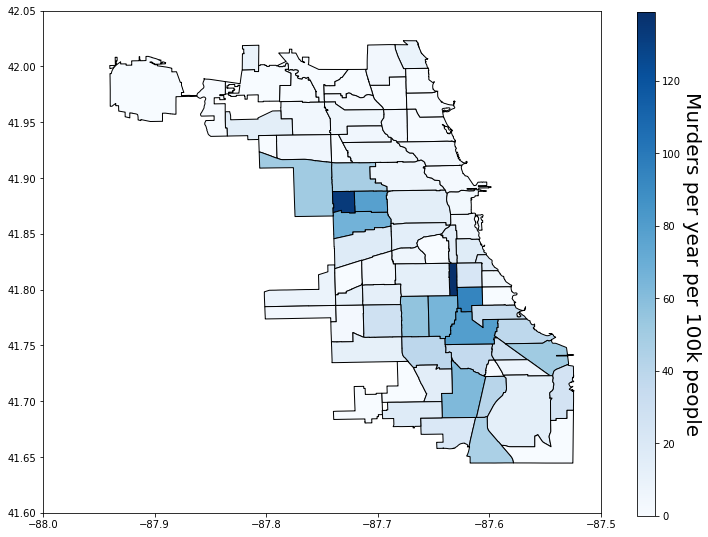

In [368]:
test_colors = np.zeros(len(neighborhood_counts))
test_colors[25] = 900000
# fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(5, 5)
ax = geodf.plot(edgecolor='k', facecolor=cmap1.to_rgba(neighborhood_rates.loc[geodf['area_num_1'].astype(int)]), figsize=(10, 10))
fig = ax.get_figure()
cax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
cbar = fig.colorbar(cmap1, cax=cax)
cbar.set_label('Murders per year per 100k people', rotation=270, fontsize=20, labelpad=20)
ax.set_xlim([-88, -87.5])
ax.set_ylim([41.6, 42.05])

NameError: name 'basemap' is not defined

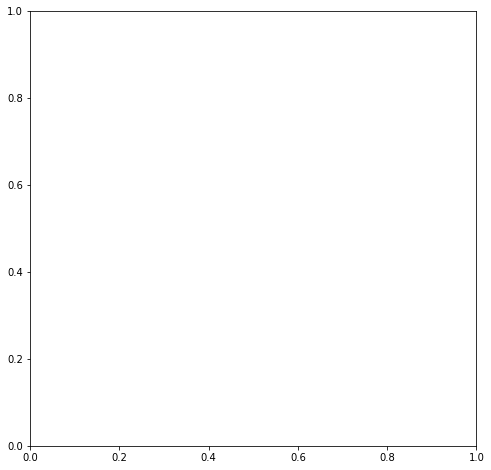

In [46]:
latmed = crimedata.Latitude.median()
lonmed = crimedata.Longitude.median()
llcrnrlat = latmed - 0.25
urcrnrlat = latmed + 0.25
llcrnrlon = lonmed - 0.3
urcrnrlon = lonmed + 0.2

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)
m = basemap.Basemap(resolution='l', projection='merc', #lat_0=latmed, lon_0=lonmed,
                    llcrnrlat=llcrnrlat, llcrnrlon=llcrnrlon, 
                    urcrnrlat=urcrnrlat, urcrnrlon=urcrnrlon)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='coral',lake_color='aqua')
m.drawcoastlines()
m.readshapefile('../datasets/Boundaries/geo_export_3b11f95d-2be3-4379-a299-434676104e08', 'Boundaries')
#m.hexbin(crimedata[crimedata['Primary Type']=='HOMICIDE'].Longitude, 
#          crimedata[crimedata['Primary Type']=='HOMICIDE'].Latitude)

In [ ]:
plt.hexbin(crimedata[crimedata['Primary Type']=='HOMICIDE'].Longitude, 
         crimedata[crimedata['Primary Type']=='HOMICIDE'].Latitude)

In [ ]:
sns.kdeplot(crimedata[crimedata['Primary Type']=='HOMICIDE'].Longitude,
         crimedata[crimedata['Primary Type']=='HOMICIDE'].Latitude) # normalize this to population density?

# Do crimes behave as a Poisson process?

Let's use 2007 as a "typical" year, since it's in the middle of a steady homicide rate.

In [ ]:
crimes2007 = crimedata[crimedata.index.year==2016]
for crimetype in ['HOMICIDE', 'THEFT', 'BATTERY']:
    subset2007 = crimes2007[crimes2007['Primary Type']==crimetype]
    subset_mean = len(subset2007)/365.0
    print('There were an average of {:.2f} '.format(subset_mean)+crimetype+' crimes per day in 2007')
    subset_counts2007 = subset2007.index.dayofyear.value_counts()

    fig, ax = plt.subplots(1, 1)
    if len(subset2007)>1000.0:
        bins = np.arange(subset_counts2007.min()-1.5, subset_counts2007.max()+1.5, 2.0)
    else:
        bins = np.arange(subset_counts2007.min()-1.5, subset_counts2007.max()+1.5, 1.0)
    ax.hist(subset_counts2007.values, bins=bins, label='Actual Counts')
    ax.plot(bins+0.5, 365.0*ss.poisson.pmf(bins+0.5, subset_mean), 'o', label='Poisson')
    ax.set_xlabel(crimetype+' Per Day')
    ax.set_ylabel('Count')
    plt.legend(loc='best')

## FFT 

In [49]:
crime_days = (crimedata.index - pd.to_datetime('Jan 01 2001')).days.value_counts().sort_index()
homicide_days = (crimedata[crimedata['Primary Type'] == 'HOMICIDE'].index - 
                 pd.to_datetime('Jan 01 2001')).days.value_counts().sort_index()

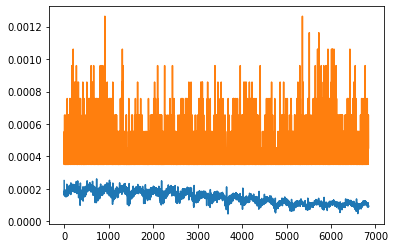

In [12]:
fig, ax = plt.subplots(1, 1)
ax.plot(crime_days/crime_days.sum())
ax.plot(homicide_days/homicide_days.sum()+0.00025)

In [50]:
homicide_fft = fft.fft(homicide_days.values)
homicide_freq = fft.fftfreq(len(homicide_days))
crime_fft = fft.fft(crime_days.values)
crime_freq = fft.fftfreq(len(crime_days))

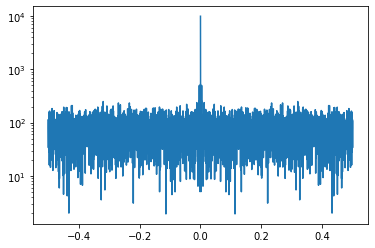

In [54]:
plt.plot(homicide_freq, np.abs(homicide_fft))
plt.yscale('log')

/home/elaad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  This is separate from the ipykernel package so we can avoid doing imports until


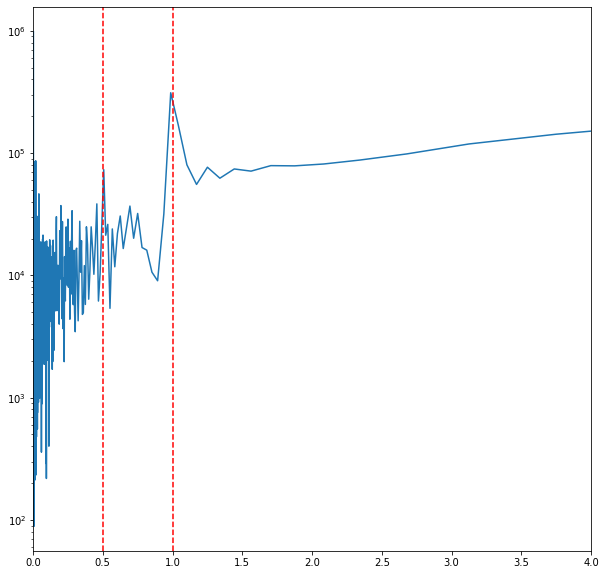

In [62]:
plt.figure(figsize=(10, 10))
# plt.plot(crime_freq, np.abs(crime_fft))
plt.plot(np.linspace(0, 1, len(crime_fft))**-1 / 365, np.abs(crime_fft))
plt.yscale('log')
# plt.loglog([], [])
plt.xlim([0, 4])
plt.axvline(1, color='red', ls='--')
plt.axvline(0.5, color='red', ls='--')

/home/elaad/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


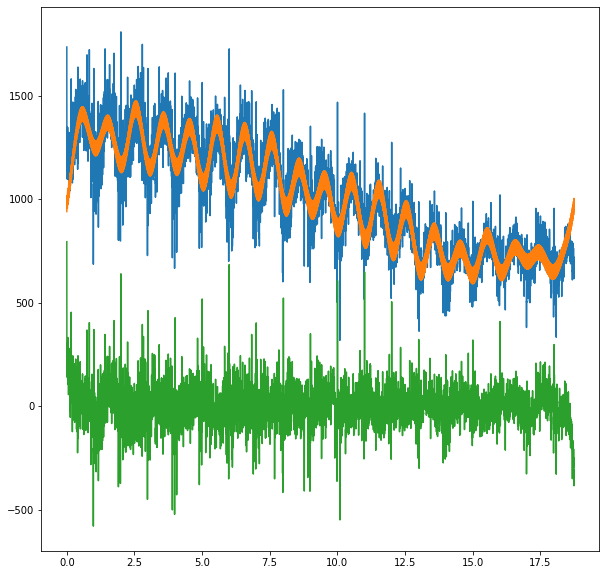

In [51]:
plt.figure(figsize=(10, 10))
filt_crime_fft = crime_fft.copy()
filt_crime_fft[np.abs(filt_crime_fft) < 75000] = 0
plt.plot(np.linspace(0, len(crime_days)/365, len(crime_days)), crime_days)
plt.plot(np.linspace(0, len(crime_days)/365, len(crime_days)), fft.ifft(filt_crime_fft))

plt.plot(np.linspace(0, len(crime_days)/365, len(crime_days)), crime_days - fft.ifft(filt_crime_fft))

In [88]:
def gaussian(x, mu, sigma):
    x = np.array(x)
    return 1. / np.sqrt((2 * np.pi * sigma)) * np.exp(-(x - mu)**2 / (2 * sigma))

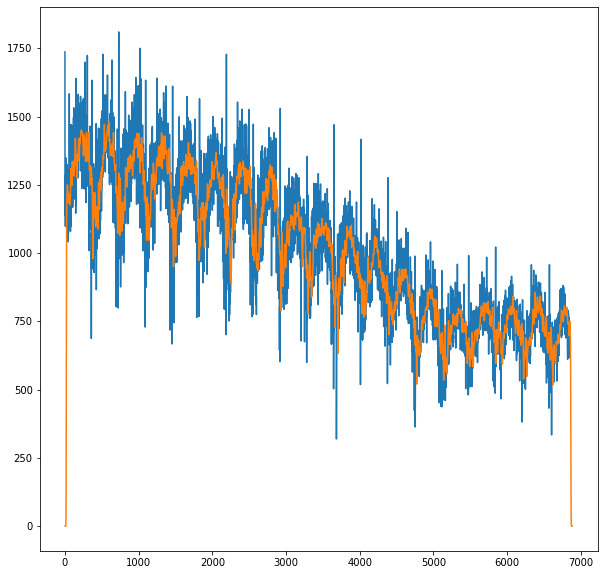

In [100]:
plt.figure(figsize=(10, 10))
plt.plot(crime_days)
plt.plot(np.convolve(crime_days, gaussian(np.arange(-20, 20, 1), 0, 7))) #gaussian smoothing with 1 week sigma